In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(100, 1152)
        self.conv_t1 = nn.ConvTranspose1d(12, 12, 3, 1, 1)
        self.conv_t2 = nn.ConvTranspose1d(12, 1, 3, 1, 1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(-1, 12, 96)
        x = F.relu(self.conv_t1(x))
        x = self.conv_t2(x)
        return F.sigmoid(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(1, 12, 3, 1, 1)
        self.conv2 = nn.Conv1d(12, 4, 3, 1, 1)
        self.fc = nn.Linear(384, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 384)
        x = F.sigmoid(self.fc(x))
        return x

In [23]:
X = np.load('../data/X.npy')
X = torch.tensor(X, dtype=torch.float32)
y = np.load('../data/y.npy')
y = torch.tensor(y, dtype=torch.float32)
X = X[y == 0]
X = (X - X.min()) / (X.max() - X.min())

In [24]:
dataloader = DataLoader(X.unsqueeze(1), batch_size=32, shuffle=True)

G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=1e-5)
optimizer_D = optim.Adam(D.parameters(), lr=1e-5)


num_epochs = 2000
epochs_per_switch = 20

train_D = True
for epoch in range(num_epochs):
    if epoch % epochs_per_switch == 0:
        train_D = not train_D
    for real_data in dataloader:
        if train_D:
            real_data = real_data + 0.01 * torch.randn_like(real_data)
            D_real = D(real_data)
            D_real_loss = criterion(D_real, torch.ones_like(D_real))
            
            fake_data = G(torch.randn(32, 1, 100))
            D_fake = D(fake_data.detach())
            D_fake_loss = criterion(D_fake, torch.zeros_like(D_fake))

            D_loss = D_real_loss + D_fake_loss
            optimizer_D.zero_grad()
            D_loss.backward()
            optimizer_D.step()
        else:
            fake_data = G(torch.randn(32, 1, 100))
            output = D(fake_data)
            
            G_loss = criterion(output, torch.ones_like(output))
            optimizer_G.zero_grad()
            G_loss.backward()
            optimizer_G.step()

    print(f"Epoch {epoch+1}/{num_epochs}, D Loss: {D_loss.item()}, G Loss: {G_loss.item()}")

Epoch 1/2000, D Loss: 1.3514776229858398, G Loss: 0.6988745331764221
Epoch 2/2000, D Loss: 1.3514776229858398, G Loss: 0.6988483667373657
Epoch 3/2000, D Loss: 1.3514776229858398, G Loss: 0.6981246471405029
Epoch 4/2000, D Loss: 1.3514776229858398, G Loss: 0.6969601511955261
Epoch 5/2000, D Loss: 1.3514776229858398, G Loss: 0.6972485780715942
Epoch 6/2000, D Loss: 1.3514776229858398, G Loss: 0.6969996690750122
Epoch 7/2000, D Loss: 1.3514776229858398, G Loss: 0.6960324048995972
Epoch 8/2000, D Loss: 1.3514776229858398, G Loss: 0.6958299875259399
Epoch 9/2000, D Loss: 1.3514776229858398, G Loss: 0.6953288912773132
Epoch 10/2000, D Loss: 1.3514776229858398, G Loss: 0.6952193379402161
Epoch 11/2000, D Loss: 1.3514776229858398, G Loss: 0.6944661736488342
Epoch 12/2000, D Loss: 1.3514776229858398, G Loss: 0.6951233744621277
Epoch 13/2000, D Loss: 1.3514776229858398, G Loss: 0.6934908032417297
Epoch 14/2000, D Loss: 1.3514776229858398, G Loss: 0.6939188241958618
Epoch 15/2000, D Loss: 1.3514

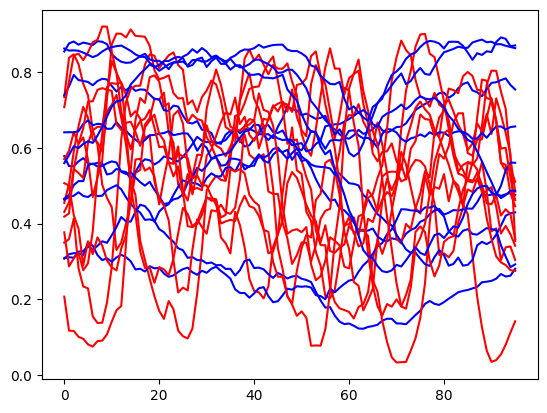

In [25]:
G.eval()
noise = torch.randn(10, 1, 100)
fake_data = G(noise)
for i in range(10):
    plt.plot(fake_data[i, 0].detach().numpy(), color='red')
    plt.plot(X[i].detach().numpy(), color='blue')
plt.show()